# Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)},
        font_scale=1.5,
        style="whitegrid")
        
from pyspark.sql import HiveContext
from pyspark.sql import SQLContext

# initialize session hive and sql environments
hiveContext = HiveContext(sc)
sqlContext = SQLContext(sc)

# Data Reading

In [3]:
project_folder = "../"
datapath = project_folder + "data/"
plotpath = project_folder + "graphs/"
mungepath = project_folder + "munge/"
configpath = project_folder + "config/"
diagnostic = project_folder + "diagnostic/"
modelpath = project_folder + "model/"
output = project_folder + "output/"

In [4]:
from pyspark.sql.functions import col

train = spark.read.csv(os.path.join(datapath,"train.csv"), header=True)
print('Found %d observations in training set.' %train.count())

Found 184903890 observations in training set.


In [5]:
from pyspark.sql.functions import col

test_old = (spark.read.csv(os.path.join(datapath,"test_supplement.csv"), header=True)
            .filter(col('click_time') >= '2017-11-09 16:00:00'))

print('Found %d observations in test_old set.' %test_old.count())

Found 57536872 observations in test_old set.


In [6]:
# test new is the reduced size test set sampled by kaggle during competition

test_new = spark.read.csv(os.path.join(datapath,"test.csv"), header=True)

print('Found %d observations in test_new set.' %test_new.count())

Found 18790469 observations in test_new set.


In [7]:
train.show(10)

+------+---+------+---+-------+-------------------+---------------+-------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|           null|            0|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|           null|            0|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|           null|            0|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|           null|            0|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|           null|            0|
| 18787|  3|     1| 16|    379|2017-11-06 14:36:26|           null|            0|
|103022|  3|     1| 23|    379|2017-11-06 14:37:44|           null|            0|
|114221|  3|     1| 19|    379|2017-11-06 14:37:59|           null|            0|
|165970|  3|     1| 13|    379|2017-11-06 14:38:10|           null|            0|
| 74544| 64|    

In [8]:
train.printSchema()

root
 |-- ip: string (nullable = true)
 |-- app: string (nullable = true)
 |-- device: string (nullable = true)
 |-- os: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: string (nullable = true)



In [34]:
test_old.select(func.max(col('click_time'))).show()

+-------------------+
|    max(click_time)|
+-------------------+
|2017-11-10 16:00:00|
+-------------------+



In [35]:
test_new.select(func.max(col('click_time'))).show()

+-------------------+
|    max(click_time)|
+-------------------+
|2017-11-10 15:00:00|
+-------------------+



# Simulate Training Set Features

In [7]:
from pyspark.sql.functions import monotonically_increasing_id

# Add unique id for each row to training set
train = (train
         .withColumn('id', monotonically_increasing_id()))
         
train.show(5)

+------+---+------+---+-------+-------------------+---------------+-------------+---+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed| id|
+------+---+------+---+-------+-------------------+---------------+-------------+---+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|           null|            0|  0|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|           null|            0|  1|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|           null|            0|  2|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|           null|            0|  3|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|           null|            0|  4|
+------+---+------+---+-------+-------------------+---------------+-------------+---+
only showing top 5 rows



For the training set, we will not consider all clicks that appear in the test set.  
This is because the test set is the last day of the whole data we have and we cannot get the clicks coming after.  
So we do not want to advantage the training set as regarding the test set. (feature avaialability should be be fair between the training and test set when thinking especially about lase_next_click).

In [9]:
from pyspark.sql.window import Window
import pyspark.sql.functions as func

# Defines partitioning specification and ordering specification.
windowSpec = \
  Window \
    .partitionBy(col('ip'), col('app')) \
    .orderBy(col('click_time').cast('timestamp'))

The following code will compute two features:  
* **lapse_prev_click**  
We will check if there is a previous click within the last 2 days. If yes, we will compute the time difference to that click otherwise we will give a maximum value that is (2\*24\*3600) if there are 2 days avaialble otherwise it will take 999999 indicating unsufficient information. That 999999 will be converted to -1 when aggregating to get one unique value for each observation in case of many similar clicks at exact same time.

* **lapse_next_click**  
We will check whether we can find similar click during the next hour. If not we will assign the lapse time to 3600.
Normally, we shoudn't care much about avaialability of next hour data as the reduced new test set end at 2017-11-10 15:00:00 when the full old test set end at 2017-11-10 16:00:00

In [107]:
from pyspark.sql.functions import unix_timestamp, col, udf, lit, when
from pyspark.sql.types import LongType

def click_last2days(time_lapse, avail_2days):
    """
    Checks if the time difference since last click is greater than 2 days
    if not, the value is kept otherwise it is converted to 2*24*3600
    In case the 2 days history are not full we will assign 999999
    
    Args:
        avail_2days -- boolean whether or not at least 2 days of history are avaialble
        time_lapse -- time since last click
    """
    if (avail_2days == True) and (time_lapse == None):
        return 2*24*3600
    elif (avail_2days == True) and (time_lapse > (2*24*3600)):
        return 2*24*3600
    elif (avail_2days == False) and (time_lapse == None):
        return 999999
    else:
        return time_lapse
    

def click_next1hour(time_lapse):
    """
    Checks if the time difference to next click is greater than 1 hour
    if not, the value is kept otherwise it is converted to 3600
    
    Args:
        time_lapse -- time since last click
    """
    if time_lapse == None:
        return 3600
    elif time_lapse > 3600:
        return 3600
    else:
        return time_lapse
    
    
click_last2days_udf = udf(click_last2days, LongType())
click_next1hour_udf = udf(click_next1hour, LongType())

f_close_clicks = (train.sample(fraction=0.1, withReplacement=False, seed=22)
                  .select('ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed')
                  .withColumn('lapse_prev_click_app',
                              unix_timestamp(col('click_time')) - unix_timestamp(func.lag(train['click_time']).over(windowSpec)))
                  .withColumn('avail2days',
                              unix_timestamp(col('click_time')) - unix_timestamp(lit('2017-11-06 14:32:21')) >= (2*24*3600))
                  .withColumn('lapse_prev_click_app', click_last2days_udf(col('lapse_prev_click_app'), col('avail2days')))
                  .withColumn('lapse_next_click_app',
                                 unix_timestamp(func.lag(train['click_time'],-1).over(windowSpec)) - unix_timestamp(col('click_time')))
                  .withColumn('lapse_next_click_app', click_next1hour_udf(col('lapse_next_click_app')))
                  .groupBy('ip', 'app', 'device', 'os', 'channel', 'click_time', 'is_attributed')
                  .agg(func.min(col('lapse_prev_click_app')).alias('lapse_prev_click_app'),
                       func.min(col('lapse_next_click_app')).alias('lapse_next_click_app'))
                  .withColumn('lapse_prev_click_app', (when(col('lapse_prev_click_app')==999999, -1)
                                                       .otherwise(col('lapse_prev_click_app'))))
                  .cache())

# Check the impact of lapse_prev_click feature

In [16]:
f_close_clicks.groupBy().agg(func.mean(col('is_attributed'))).show()

+--------------------+
|  avg(is_attributed)|
+--------------------+
|0.002484407307574...|
+--------------------+



In [13]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [108]:
PDF = f_close_clicks.select('is_attributed', 'lapse_prev_click_app').toPandas()

In [17]:
PDF.head()

,is_attributed,lapse_prev_click_app
0,0,64
1,0,442
2,0,129256
3,0,2615
4,0,50


In [109]:
PDF_sorted = PDF.sort_values(by='lapse_prev_click_app')

In [110]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [111]:
PDF_sorted.head()

,is_attributed,lapse_prev_click_app,roll
9229162,0,-1,NaN
10585653,0,-1,NaN
1755732,0,-1,NaN
10585664,0,-1,NaN
10585682,0,-1,NaN


Let's visualize the impact of of last click lapse time variable on the download rate

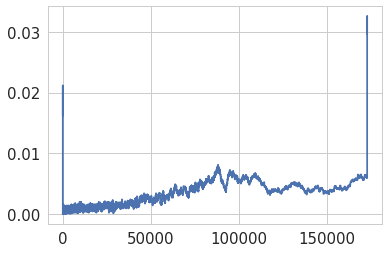

In [112]:
plt.plot(PDF_sorted.lapse_prev_click_app, PDF_sorted.roll)

Download rate when we don't have complete info during the last two days

In [113]:
PDF[PDF['lapse_prev_click_app']==-1]['is_attributed'].astype(float).mean()

0.016523761245557367

Download rate when the click is unknown in the last two days

In [114]:
PDF[PDF['lapse_prev_click_app']==(2*24*3600)]['is_attributed'].astype(float).mean()

0.027543334709038383

This corresponds to 10 times more chance to download !

In [115]:
len(PDF[PDF['lapse_prev_click_app']==(2*24*3600)]['is_attributed'])

387680

# Check the impact of lapse_next_click feature

In [16]:
f_close_clicks.groupBy().agg(func.mean(col('is_attributed'))).show()

+--------------------+
|  avg(is_attributed)|
+--------------------+
|0.002484407307574...|
+--------------------+



In [13]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [116]:
PDF = f_close_clicks.select('is_attributed', 'lapse_next_click_app').toPandas()

In [117]:
PDF.head()

,is_attributed,lapse_next_click_app
0,0,1337
1,0,1186
2,0,409
3,0,1532
4,0,3600


In [118]:
PDF_sorted = PDF.sort_values(by='lapse_next_click_app')

In [119]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [120]:
PDF_sorted.head()

,is_attributed,lapse_next_click_app,roll
15493274,0,0,NaN
7165860,0,0,NaN
5107863,0,0,NaN
1325250,0,0,NaN
309133,0,0,NaN


Let's visualize the impact of of last click lapse time variable on the download rate

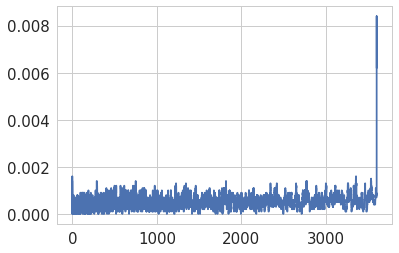

In [121]:
plt.plot(PDF_sorted.lapse_next_click_app, PDF_sorted.roll)

Download rate when we the next click is within 10 seconds

In [67]:
PDF[PDF['lapse_next_click_app']==0]['is_attributed'].astype(float).mean()

0.0009322815285319128

This variable does not seem very powerfull

In [70]:
len(PDF[PDF['lapse_next_click_app']==0]['is_attributed'])

97610

Download rate when there is no click in the next one hour

In [68]:
PDF[PDF['lapse_next_click_app']==3600]['is_attributed'].astype(float).mean()

0.005584073379615965

This corresponds to 10 times more chance to download !

In [71]:
len(PDF[PDF['lapse_next_click_app']==3600]['is_attributed'])

7334789

# Extract Training Set Features

In [15]:
from pyspark.sql.functions import monotonically_increasing_id

# Add unique id for each row to training set
train = (train
         .withColumn('id', monotonically_increasing_id()))
         
train.show(5)

+------+---+------+---+-------+-------------------+---------------+-------------+---+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed| id|
+------+---+------+---+-------+-------------------+---------------+-------------+---+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|           null|            0|  0|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|           null|            0|  1|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|           null|            0|  2|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|           null|            0|  3|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|           null|            0|  4|
+------+---+------+---+-------+-------------------+---------------+-------------+---+
only showing top 5 rows



For the training set, we will not consider all clicks that appear in the test set.  
This is because the test set is the last day of the whole data we have and we cannot get the clicks coming after.  
So we do not want to advantage the training set as regarding the test set. (feature avaialability should be be fair between the training and test set when thinking especially about lase_next_click).

In [10]:
from pyspark.sql.window import Window
import pyspark.sql.functions as func

# Defines partitioning specification and ordering specification.
windowSpec = \
  Window \
    .partitionBy(col('ip'), col('app')) \
    .orderBy(col('click_time').cast('timestamp'))

The following code will compute two features:  
* **lapse_prev_click**  
We will check if there is a previous click within the last 2 days. If yes, we will compute the time difference to that click otherwise we will give a maximum value that is (2\*24\*3600) if there are 2 days avaialble otherwise it will take 999999 indicating unsufficient information. That 999999 will be converted to -1 when aggregating to get one unique value for each observation in case of many similar clicks at exact same time.

* **lapse_next_click**  
We will check whether we can find similar click during the next hour. If not we will assign the lapse time to 3600.
Normally, we shoudn't care much about avaialability of next hour data as the reduced new test set end at 2017-11-10 15:00:00 when the full old test set end at 2017-11-10 16:00:00

In [ ]:
from pyspark.sql.functions import unix_timestamp, col, udf, lit, when
from pyspark.sql.types import LongType

def click_last2days(time_lapse, avail_2days):
    """
    Checks if the time difference since last click is greater than 2 days
    if not, the value is kept otherwise it is converted to 2*24*3600
    In case the 2 days history are not full we will assign 999999
    
    Args:
        avail_2days -- boolean whether or not at least 2 days of history are avaialble
        time_lapse -- time since last click
    """
    if (avail_2days == True) and (time_lapse == None):
        return 2*24*3600
    elif (avail_2days == True) and (time_lapse > (2*24*3600)):
        return 2*24*3600
    elif (avail_2days == False) and (time_lapse == None):
        return 999999
    else:
        return time_lapse
    

def click_next1hour(time_lapse):
    """
    Checks if the time difference to next click is greater than 1 hour
    if not, the value is kept otherwise it is converted to 3600
    
    Args:
        time_lapse -- time since last click
    """
    if time_lapse == None:
        return 3600
    elif time_lapse > 3600:
        return 3600
    else:
        return time_lapse
    
    
click_last2days_udf = udf(click_last2days, LongType())
click_next1hour_udf = udf(click_next1hour, LongType())

In [11]:
f_close_clicks = (train
                  .select('ip', 'app', 'device', 'os', 'channel', 'click_time')
                  .withColumn('lapse_prev_click_app',
                              unix_timestamp(col('click_time')) - unix_timestamp(func.lag(train['click_time']).over(windowSpec)))
                  .withColumn('avail2days',
                              unix_timestamp(col('click_time')) - unix_timestamp(lit('2017-11-06 14:32:21')) >= (2*24*3600))
                  .withColumn('lapse_prev_click_app', click_last2days_udf(col('lapse_prev_click_app'), col('avail2days')))
                  .withColumn('lapse_next_click_app',
                                 unix_timestamp(func.lag(train['click_time'],-1).over(windowSpec)) - unix_timestamp(col('click_time')))
                  .withColumn('lapse_next_click_app', click_next1hour_udf(col('lapse_next_click_app')))
                  .groupBy('ip', 'app', 'device', 'os', 'channel', 'click_time')
                  .agg(func.min(col('lapse_prev_click_app')).alias('lapse_prev_click_app'),
                       func.min(col('lapse_next_click_app')).alias('lapse_next_click_app'))
                  .withColumn('lapse_prev_click_app', (when(col('lapse_prev_click_app')==999999, -1)
                                                       .otherwise(col('lapse_prev_click_app')))))

In [18]:
f_close_clicks_train = (train
                        .join(f_close_clicks, ['ip', 'app', 'device', 'os', 'channel', 'click_time'], 'left_outer')
                        .orderBy(col('id')))

In [19]:
f_close_clicks_train.filter(col('ip')==83230).show(5, truncate=False)

+-----+---+------+---+-------+-------------------+---------------+-------------+-----+--------------------+--------------------+
|ip   |app|device|os |channel|click_time         |attributed_time|is_attributed|id   |lapse_prev_click_app|lapse_next_click_app|
+-----+---+------+---+-------+-------------------+---------------+-------------+-----+--------------------+--------------------+
|83230|3  |1     |13 |379    |2017-11-06 14:32:21|null           |0            |0    |-1                  |3600                |
|83230|2  |1     |3  |477    |2017-11-06 16:00:31|null           |0            |24831|-1                  |25                  |
|83230|12 |1     |13 |178    |2017-11-06 16:00:48|null           |0            |43179|-1                  |164                 |
|83230|9  |1     |13 |134    |2017-11-06 16:00:50|null           |0            |44757|-1                  |37                  |
|83230|2  |1     |19 |237    |2017-11-06 16:00:56|null           |0            |51216|25         

In [20]:
(f_close_clicks_train
 .select("id", "lapse_prev_click_app", "lapse_next_click_app")
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_close_clicks_app_train", compression="None"))

# Extract Test Set Features

In [12]:
from pyspark.sql.functions import monotonically_increasing_id

# Add a unique id for each row in the test set
test_new = (test_new
            .withColumn('id', monotonically_increasing_id()))

In [13]:
test_new.show(10)

+--------+------+---+------+---+-------+-------------------+---+
|click_id|    ip|app|device| os|channel|         click_time| id|
+--------+------+---+------+---+-------+-------------------+---+
|       0|  5744|  9|     1|  3|    107|2017-11-10 04:00:00|  0|
|       1|119901|  9|     1|  3|    466|2017-11-10 04:00:00|  1|
|       2| 72287| 21|     1| 19|    128|2017-11-10 04:00:00|  2|
|       3| 78477| 15|     1| 13|    111|2017-11-10 04:00:00|  3|
|       4|123080| 12|     1| 13|    328|2017-11-10 04:00:00|  4|
|       5|110769| 18|     1| 13|    107|2017-11-10 04:00:00|  5|
|       6| 12540|  3|     1|  1|    137|2017-11-10 04:00:00|  6|
|       7| 88637| 27|     1| 19|    153|2017-11-10 04:00:00|  7|
|       9| 14932| 18|     1| 10|    107|2017-11-10 04:00:00|  8|
|       8|123701| 12|     1| 53|    424|2017-11-10 04:00:00|  9|
+--------+------+---+------+---+-------+-------------------+---+
only showing top 10 rows



In [14]:
# train and test set concatenation
from pyspark.sql.functions import col
data = (train.select('ip', 'app', 'device', 'os', 'channel', 'click_time')
        .unionAll(test_old.select('ip', 'app', 'device', 'os', 'channel', 'click_time')))
        
print('Total number of clicks in one week:', data.count())

Total number of clicks in one week: 242440762


In [15]:
data.show(3)

+-----+---+------+---+-------+-------------------+
|   ip|app|device| os|channel|         click_time|
+-----+---+------+---+-------+-------------------+
|83230|  3|     1| 13|    379|2017-11-06 14:32:21|
|17357|  3|     1| 19|    379|2017-11-06 14:33:34|
|35810|  3|     1| 13|    379|2017-11-06 14:34:12|
+-----+---+------+---+-------+-------------------+
only showing top 3 rows



In [18]:
from pyspark.sql.functions import unix_timestamp, col

f_close_clicks = (data
                  .select('ip', 'app', 'device', 'os', 'channel', 'click_time')
                  .withColumn('lapse_prev_click_app',
                              unix_timestamp(col('click_time')) - unix_timestamp(func.lag(train['click_time']).over(windowSpec)))
                  .withColumn('avail2days',
                              unix_timestamp(col('click_time')) - unix_timestamp(lit('2017-11-06 14:32:21')) >= (2*24*3600))
                  .withColumn('lapse_prev_click_app', click_last2days_udf(col('lapse_prev_click_app'), col('avail2days')))
                  .withColumn('lapse_next_click_app',
                                 unix_timestamp(func.lag(train['click_time'],-1).over(windowSpec)) - unix_timestamp(col('click_time')))
                  .withColumn('lapse_next_click_app', click_next1hour_udf(col('lapse_next_click_app')))
                  .groupBy('ip', 'app', 'device', 'os', 'channel', 'click_time')
                  .agg(func.min(col('lapse_prev_click_app')).alias('lapse_prev_click_app'),
                       func.min(col('lapse_next_click_app')).alias('lapse_next_click_app'))
                  .withColumn('lapse_prev_click_app', (when(col('lapse_prev_click_app')==999999, -1)
                                                       .otherwise(col('lapse_prev_click_app'))))
                  .cache())

In [19]:
f_close_clicks_test = (test_new
                       .join(f_close_clicks, ['ip', 'app', 'device', 'os', 'channel', 'click_time'], 'left_outer')
                       .orderBy(col('id')))

In [20]:
(f_close_clicks_test
 .select("id", "lapse_prev_click_app", "lapse_next_click_app")
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_close_clicks_app_test", compression="None"))

In [21]:
# do the same thing for the full test set
test_old = (test_old
            .withColumn('id', monotonically_increasing_id()))
            
f_close_clicks_test_old = (test_old
                           .join(f_close_clicks, ['ip', 'app', 'device', 'os', 'channel', 'click_time'], 'left_outer')
                           .orderBy(col('id')))
                            
(f_close_clicks_test_old
 .select("id", "lapse_prev_click_app", "lapse_next_click_app")
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_close_clicks_app_test_old", compression="None"))